# Modern version of im2gps download script

In [2]:
# Make sure to run:
# apt install python3-flickrapi

import time
import datetime
import json
import io
import concurrent.futures
import threading
import queue

from pathlib import Path
from typing import NamedTuple

import numpy as np
import pandas
import requests
import flickrapi
import tqdm
import tqdm.notebook

FLICKR_API_KEY, FLICKR_API_SECRET = \
    [l.strip() for l in open("../../../api_keys/flickr.txt").readlines()]

DATASET_ROOT = Path.home() / "datasets" / "im2gps"
QUERY_OUT_PATH = DATASET_ROOT / "outputs" / "query"

ModuleNotFoundError: No module named 'flickrapi'

In [50]:
# Parse queries file
QUERIES_INPUT_FILE = DATASET_ROOT / "inputs" / "place_rec_queries.txt"

def read_query_lines():
    with QUERIES_INPUT_FILE.open(encoding="latin_1") as f:
        for raw_line in f.readlines():
            line = raw_line.strip()
            if len(line) < 1:
                continue
            if line[0] == '#':
                continue
            yield line


# First read all negative queries
neg_queries = []
for line in read_query_lines():
    if line[0] == '-':
        neg_queries.append(line)
neg_query_string = " ".join(neg_queries)

# Generate list of queries
class QueryTag(NamedTuple):
    tag: str
    query_str: str

ALL_QUERIES = []
for line in read_query_lines():
    if line[0] == '-':
        continue
    ALL_QUERIES.append(
        QueryTag(
            tag=line,
            query_str=f"{line} {neg_query_string}"
        )
    )

ALL_QUERIES

[QueryTag(tag='Tokyo', query_str='Tokyo -birthday -party -parties -people -portrait -bw -abstract -macro -me -wedding -indoors -fun -kid -child -children -graffiti -prom -concert -friend -family -dog -cat -face -cameraphone -woman -women -girl -lady -boy -guy -nude -fraternity -frat -gay -lesbian -live -baby -stilllife'),
 QueryTag(tag='Seoul', query_str='Seoul -birthday -party -parties -people -portrait -bw -abstract -macro -me -wedding -indoors -fun -kid -child -children -graffiti -prom -concert -friend -family -dog -cat -face -cameraphone -woman -women -girl -lady -boy -guy -nude -fraternity -frat -gay -lesbian -live -baby -stilllife'),
 QueryTag(tag='MexicoCity', query_str='MexicoCity -birthday -party -parties -people -portrait -bw -abstract -macro -me -wedding -indoors -fun -kid -child -children -graffiti -prom -concert -friend -family -dog -cat -face -cameraphone -woman -women -girl -lady -boy -guy -nude -fraternity -frat -gay -lesbian -live -baby -stilllife'),
 QueryTag(tag='nyc

In [51]:
# Configure time-based search algo

MIN_BLOCK_PHOTOS = 150
#MAX_BLOCK_PHOTOS = 250
#INITIAL_BLOCK_LEN = 900 # 15 minutes
INITIAL_BLOCK_LEN = 2 * 60 * 60 # 2 hours

# Start/end times from im2gps
SEARCH_START_TIME = 1171416400 # 2007-02-14T01:26:40Z
SEARCH_END_TIME = 1192165200 # 2007-10-12T05:00:00Z

# TODO: expand start/end times

In [106]:
# Pass store_token=False to work around https://github.com/sybrenstuvel/flickrapi/issues/75
# (We don't need user auth anyways)
FAPI = flickrapi.FlickrAPI(FLICKR_API_KEY, FLICKR_API_SECRET, format="parsed-json", store_token=False)

class Searcher:
    def __init__(self):
        self.last_api_time = None

    def search_time_range(self, query_str, min_date: int, max_date: int, page: int = 1):
        # min_date and max_date are Unix timestamps

        # Wait at least 1.2 seconds since last API call
        start_time = time.time()
        if self.last_api_time is not None:
            wait_time = max(0, 1.2 - (start_time - self.last_api_time))
            time.sleep(wait_time)
        self.last_api_time = start_time

        return FAPI.photos.search(
            privacy_filter="1", # public only
            text=query_str,
            media="photos",
            has_geo="1",
            accuracy="6", # region level
            min_upload_date=min_date,
            max_upload_date=max_date,
            sort="interestingness-desc",
            page=page,
            per_page=250,
            extras="geo,date_upload"
        )

s = Searcher()

def query_save_one_tag(qt: QueryTag):
    block_start = SEARCH_START_TIME
    block_len = INITIAL_BLOCK_LEN

    # Skip the query if we already have results
    out_path = QUERY_OUT_PATH / f"{qt.tag}.pkl"
    if out_path.exists():
        print(f"{qt.tag}: already exists, skipping")
        return

    results_df = pandas.DataFrame()

    try:
        while block_start < SEARCH_END_TIME:
            results = s.search_time_range(qt.query_str, block_start, block_start + block_len - 1)
            total_results = results["photos"]["total"] 
            print(f"  {qt.tag}: block {block_start}->{block_start+block_len} total {total_results}")
            if total_results < MIN_BLOCK_PHOTOS and block_start + block_len < SEARCH_END_TIME:
                block_len = int(block_len * 2)
                continue

            # Found a good block_len
            print(f"{qt.tag}: block {block_start}->{block_start+block_len} total {total_results}")

            # Read all of the pages
            for page_num in range(1, results["photos"]["pages"]):
                if page_num > 1:
                    print(f"  {qt.tag}: page {page_num}")
                    results = s.search_time_range(qt.query_str, block_start, block_start + block_len - 1, page=page_num)
                photos_json = io.StringIO(json.dumps(results["photos"]["photo"]))
                df = pandas.read_json(photos_json, orient="records")
                if len(df.index) == 0:
                    continue

                # Fix dtypes
                if df["server"].dtype != np.int64:
                    df["server"] = df["server"].astype(np.int64)
                df["interestingness"] = df.index.to_numpy() + (page_num - 1) * 250
                results_df = pandas.concat([results_df, df], ignore_index=True)

            block_start += block_len
            block_len = INITIAL_BLOCK_LEN
    except flickrapi.FlickrError as e:
        print(f"{qt.tag}: error: {e}")
        return

    # Save results
    results_df.to_pickle(out_path)
    print(f"{qt.tag}: saved to {out_path}")


for qt in ALL_QUERIES:
    query_save_one_tag(qt)

Tokyo: already exists, skipping
Seoul: already exists, skipping
MexicoCity: already exists, skipping
nyc: already exists, skipping
NewYorkCity: already exists, skipping
SaoPaulo: already exists, skipping
Mumbai: already exists, skipping
Bombay: already exists, skipping
Cairo: already exists, skipping
Delhi: already exists, skipping
Shanghai: already exists, skipping
Kolkata: already exists, skipping
Calcutta: already exists, skipping
Moscow: already exists, skipping
Jakarta: already exists, skipping
LosAngeles: already exists, skipping
BuenosAires: already exists, skipping
Dhaka: already exists, skipping
Osaka: already exists, skipping
London: already exists, skipping
Karachi: already exists, skipping
Paris: already exists, skipping
RiodeJaneiro: already exists, skipping
Istanbul: already exists, skipping
Lagos: already exists, skipping
Beijing: already exists, skipping
Manila: already exists, skipping
Chicago: already exists, skipping
Guangzhou: already exists, skipping
Lima: already 

In [107]:
df = pandas.read_pickle(QUERY_OUT_PATH / "Hungary.pkl")
np.sum(df["server"].isnull())

0

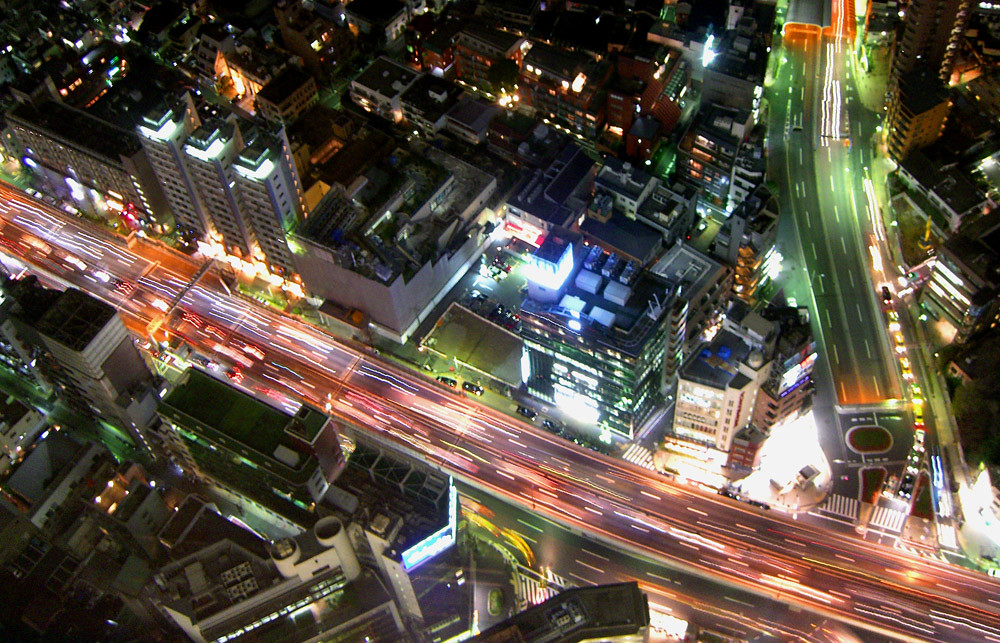

In [68]:
row = df.iloc[0]
r = requests.get(f"https://live.staticflickr.com/{row.server}/{row.id}_{row.secret}_b.jpg")
r.raise_for_status()
with open("/tmp/test.jpg", "wb") as f:
    f.write(r.content)

from IPython.display import Image
Image(filename="/tmp/test.jpg")

In [110]:
import numpy as np

# Assemble all the results into a single dataframe
dataset_df = pandas.DataFrame()
for qt in ALL_QUERIES:
    out_path = QUERY_OUT_PATH / f"{qt.tag}.pkl"
    if out_path.exists():
        query_df = pandas.read_pickle(out_path)
        if len(query_df.index) == 0:
            #print(f"No results {qt.tag}")
            continue
        if query_df["server"].dtype != np.int64:
            print(f"Weird dtype {qt.tag} {query_df['server'].dtype}")
            continue
        query_df["tag"] = qt.tag
        dataset_df = pandas.concat([dataset_df, query_df], ignore_index=True)
    else:
        print(f"No file {out_path}")

dataset_df.to_pickle(DATASET_ROOT / "outputs" / "im2gps.pkl")
dataset_df

,id,owner,secret,server,farm,title,ispublic,isfriend,isfamily,dateupload,...,accuracy,context,place_id,woeid,geo_is_public,geo_is_contact,geo_is_friend,geo_is_family,interestingness,tag
0,398492752,17392647@N00,e3152820b2,169,1,Tokyo roads,1,0,0,1172128070,...,12,0,cLK5.HBQU7vUgaJM,1112372.0,1,0,0,0,0,Tokyo
1,399391800,18063597@N00,3b9c65a793,180,1,kagoshima; sunset of shibushi,1,0,0,1172202141,...,11,0,V76rittTWrkjLNIbDQ,28379412.0,1,0,0,0,1,Tokyo
2,397737291,88468856@N00,f7572f28ed,164,1,fall into despair,1,0,0,1172074105,...,12,0,FRthiQZQU7uKHvmP,1118370.0,1,0,0,0,2,Tokyo
3,391903677,58776404@N00,0d983cd099,131,1,[Kichijouji]_070213_085 Enpty Line,1,0,0,1171618333,...,16,0,2Eh6._NQV7rv6f0AjQ,15015379.0,1,0,0,0,3,Tokyo
4,397665565,36516818@N00,c3160578b6,149,1,City View,1,0,0,1172068796,...,16,0,,26198557.0,1,0,0,0,4,Tokyo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635621,1333492953,12630498@N02,001e9c9761,1066,2,DSCN3823,1,0,0,1189058877,...,16,0,NaN,NaN,1,0,0,0,495,antarctica
635622,1332913387,12630498@N02,97154b051f,1088,2,DSCN3795,1,0,0,1189049793,...,16,0,NaN,NaN,1,0,0,0,496,antarctica
635623,1333783146,12630498@N02,600f398539,1216,2,DSCN3784,1,0,0,1189049386,...,16,0,NaN,NaN,1,0,0,0,497,antarctica
635624,1332879671,12630498@N02,1733430e6f,1259,2,DSCN3776,1,0,0,1189049048,...,16,0,NaN,NaN,1,0,0,0,498,antarctica


In [2]:
# Download all images in parallel
class Downloader:
    def __init__(self):
        self.semaphore = threading.Semaphore(1)
        self.quit_queue = queue.Queue()

    def token_filler(self, secs_per_token: float):
        while True:
            try:
                self.quit_queue.get(timeout=secs_per_token)
                return
            except queue.Empty:
                self.semaphore.release()

    def download_one(self, index, row, rate_limited=False):
        subdir = DATASET_ROOT / "outputs" / "img" / row.tag / '{:05d}'.format(index//1000)
        subdir.mkdir(parents=True, exist_ok=True)

        out_path = (subdir / f"{row.id}_{row.secret}_{row.server}_{row.owner}.jpg")
        if out_path.exists():
            if out_path.stat().st_size > 0:
                #print(f"Skipping {out_path}")
                return

        if rate_limited:
            self.semaphore.acquire()

        # Unlike the original im2gps code, we only download the 1024 size one.
        # No resizing, etc. (this can be done with PyTorch transforms)
        # We skip the original so that we don't have to deal with different file formats
        with requests.get(f"https://live.staticflickr.com/{row.server}/{row.id}_{row.secret}_b.jpg", stream=True) as r:
            r.raise_for_status()

            # From https://stackoverflow.com/questions/16694907/download-large-file-in-python-with-requests
            with out_path.open("wb") as f:
                for chunk in r.iter_content(chunk_size=512*1024):
                    f.write(chunk)
            #print(f"Downloaded {out_path}")

    def download_all(self, df):
        try:
            filler_thread = threading.Thread(target=self.token_filler, args=(0.2,))
            with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
                futures = [executor.submit(self.download_one, index, row, rate_limited=True) for index, row in df.iterrows()]
                print("Submitted all futures")
                filler_thread.start()
                with tqdm.tqdm(total=len(futures)) as pbar:
                    for future in concurrent.futures.as_completed(futures):
                        pbar.update(1)
        finally:
            self.quit_queue.put(True)
        filler_thread.join()
        
dataset_df = pandas.read_pickle(DATASET_ROOT / "outputs" / "im2gps_2007.pkl")
d = Downloader()
#d.download_one(dataset_df.index[0], dataset_df.iloc[0])
d.download_all(dataset_df)

  0%|          | 0/635626 [00:00<?, ?it/s]

Submitted all futures


100%|██████████| 635626/635626 [35:21:35<00:00,  4.99it/s]   


In [11]:
# TODO: create a webdataset from images and metadata (as json)
import pandas
import tqdm
DATASET_ROOT = Path.home() / "datasets" / "im2gps"

import webdataset

def row_subdir(row):
    return DATASET_ROOT / "outputs" / "img" / row.tag / '{:05d}'.format(index//1000)
def row_filename_stem(row):
    return f"{row.id}_{row.secret}_{row.server}_{row.owner}"

dataset_df = pandas.read_pickle(DATASET_ROOT / "outputs" / "im2gps_2007.pkl")
with webdataset.ShardWriter(str(DATASET_ROOT / "outputs" / "wds" / "im2gps_2007_%03d.tar"), encoder=False) as sink:
    for index, row in tqdm.tqdm(dataset_df.iterrows(), total=len(dataset_df.index)):
        img_path = row_subdir(row) / f"{row_filename_stem(row)}.jpg"
        if not img_path.exists():
            continue

        wds_object = {
            "__key__": row_filename_stem(row),
            "jpg": img_path.read_bytes(),
            "json": json.dumps(row.to_dict()).encode("utf-8"),
        }
        sink.write(wds_object)

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_000.tar 0 0.0 GB 0


  3%|▎         | 16343/635626 [00:27<1:02:23, 165.42it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_001.tar 16273 3.0 GB 16273


  5%|▌         | 33296/635626 [00:58<23:04, 435.18it/s]  

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_002.tar 16937 3.0 GB 33210


  8%|▊         | 49922/635626 [01:20<17:26, 559.69it/s] 

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_003.tar 16571 3.0 GB 49781


 10%|█         | 66534/635626 [01:49<13:28, 704.23it/s]  

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_004.tar 16671 3.0 GB 66452


 13%|█▎        | 83087/635626 [02:18<14:33, 632.83it/s]  

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_005.tar 16507 3.0 GB 82959


 16%|█▌        | 100078/635626 [02:48<12:11, 731.84it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_006.tar 17012 3.0 GB 99971


 18%|█▊        | 117058/635626 [03:17<12:31, 689.83it/s]  

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_007.tar 16992 3.0 GB 116963


 21%|██        | 134426/635626 [03:48<15:58, 523.07it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_008.tar 17305 3.0 GB 134268


 24%|██▍       | 151355/635626 [04:17<11:32, 699.02it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_009.tar 16915 3.0 GB 151183


 26%|██▋       | 168292/635626 [04:46<12:11, 639.26it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_010.tar 16946 3.0 GB 168129


 29%|██▉       | 184383/635626 [05:16<09:47, 768.32it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_011.tar 16089 3.0 GB 184218


 31%|███▏      | 199958/635626 [05:45<14:16, 508.39it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_012.tar 15638 3.0 GB 199856


 34%|███▍      | 216056/635626 [06:18<14:09, 494.11it/s]  

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_013.tar 16060 3.0 GB 215916


 36%|███▋      | 231354/635626 [06:47<10:21, 650.63it/s]  

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_014.tar 15287 3.0 GB 231203


 39%|███▉      | 247070/635626 [07:18<09:43, 666.13it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_015.tar 15740 3.0 GB 246943


 41%|████▏     | 263381/635626 [07:50<09:11, 675.07it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_016.tar 16285 3.0 GB 263228


 44%|████▍     | 278511/635626 [08:20<10:41, 556.98it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_017.tar 15176 3.0 GB 278404


 46%|████▋     | 294003/635626 [08:53<07:35, 749.76it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_018.tar 15371 3.0 GB 293775


 49%|████▊     | 309773/635626 [09:23<07:54, 686.23it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_019.tar 15848 3.0 GB 309623


 51%|█████▏    | 326515/635626 [09:56<27:19, 188.58it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_020.tar 16746 3.0 GB 326369


 54%|█████▍    | 342915/635626 [10:27<07:39, 637.29it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_021.tar 16329 3.0 GB 342698


 56%|█████▋    | 358748/635626 [10:58<06:48, 678.05it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_022.tar 15927 3.0 GB 358625


 59%|█████▉    | 375652/635626 [11:30<06:01, 719.62it/s] 

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_023.tar 16799 3.0 GB 375424


 62%|██████▏   | 391844/635626 [12:01<07:48, 520.44it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_024.tar 16198 3.0 GB 391622


 64%|██████▍   | 407535/635626 [12:33<05:29, 693.23it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_025.tar 15707 3.0 GB 407329


 67%|██████▋   | 423613/635626 [13:03<05:56, 594.17it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_026.tar 16093 3.0 GB 423422


 69%|██████▉   | 440265/635626 [13:35<04:35, 708.23it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_027.tar 16670 3.0 GB 440092


 72%|███████▏  | 456762/635626 [14:05<06:57, 428.49it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_028.tar 16531 3.0 GB 456623


 74%|███████▍  | 472961/635626 [14:38<03:49, 707.67it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_029.tar 16168 3.0 GB 472791


 77%|███████▋  | 489589/635626 [15:08<04:11, 579.59it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_030.tar 16700 3.0 GB 489491


 80%|███████▉  | 505496/635626 [15:40<03:28, 622.85it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_031.tar 15832 3.0 GB 505323


 82%|████████▏ | 521321/635626 [16:10<03:38, 521.98it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_032.tar 15813 3.0 GB 521136


 85%|████████▍ | 538277/635626 [16:44<02:21, 687.87it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_033.tar 16946 3.0 GB 538082


 87%|████████▋ | 555055/635626 [17:13<01:51, 723.56it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_034.tar 16735 3.0 GB 554817


 90%|█████████ | 572283/635626 [17:46<03:10, 332.69it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_035.tar 17248 3.0 GB 572065


 93%|█████████▎| 588279/635626 [18:16<01:10, 669.52it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_036.tar 15946 3.0 GB 588011


 95%|█████████▌| 604824/635626 [18:48<00:59, 520.71it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_037.tar 16547 3.0 GB 604558


 98%|█████████▊| 621304/635626 [19:20<00:21, 667.15it/s]

# writing /home/fyhuang/datasets/im2gps/outputs/wds/im2gps_2007_038.tar 16462 3.0 GB 621020


100%|██████████| 635626/635626 [19:46<00:00, 535.66it/s] 
